# Liver Image Classification with Neural Network

## Set Up

In [1]:
!pip install kagglehub


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install opencv-python


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!python -m pip install albumentations


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip install torchvision

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 11.9 MB/s eta 0:00:00


In [148]:
import os
import cv2
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import random
import shutil
import albumentations as A
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize
from torchvision import transforms as T
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

## Data

The dataset can be found here: https://www.kaggle.com/datasets/orvile/annotated-ultrasound-liver-images-dataset

This dataset contains a collection of annotated ultrasound images of the liver, designed to aid in the development of computer vision models for liver analysis, segmentation, and disease detection. The annotations include outlines of the liver and liver mass regions, as well as classifications into benign, malignant, and normal cases.

In [41]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("orvile/annotated-ultrasound-liver-images-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\WoojaeChung\.cache\kagglehub\datasets\orvile\annotated-ultrasound-liver-images-dataset\versions\2


In [90]:
files = os.listdir(path)
print("Files and directories in the dataset directory:", files)

Files and directories in the dataset directory: ['7272660', 'dataset.csv']


In [117]:
# For rerunning: Removes the directories that will be made in subsequent code

dirs_to_remove = ["resized", "resized_transformed"]

for d in dirs_to_remove:
    dir_path = os.path.join(path, d)
    if os.path.isdir(dir_path):
        print(f"Removing directory: {dir_path}")
        shutil.rmtree(dir_path)
    else:
        print(f"Directory not found, skipping: {dir_path}")

Removing directory: C:\Users\WoojaeChung\.cache\kagglehub\datasets\orvile\annotated-ultrasound-liver-images-dataset\versions\2\resized
Removing directory: C:\Users\WoojaeChung\.cache\kagglehub\datasets\orvile\annotated-ultrasound-liver-images-dataset\versions\2\resized_transformed


Assumption on the subdirectories:

- outline: A polygon outlining the entire area of interest, or perhaps the outer boundary of the liver region in a more approximate way.

- mass: A polygon specifically bounding the region of the liver mass (tumor/lesion).

- liver: A polygon bounding the liver as a whole (i.e., the organ boundary).

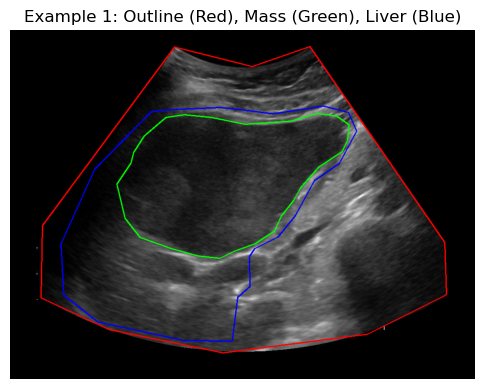

In [46]:
# Plotting an example of liver image with the annotations

base_path = path + "/7272660/Benign/Benign/"

# File paths for image and corresponding annotation JSON files for example #1
image_path   = base_path + "image/1.jpg"
outline_path = base_path + "segmentation/outline/1.json"
mass_path    = base_path + "segmentation/mass/1.json"
liver_path   = base_path + "segmentation/liver/1.json"

# Load image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert the image from BGR (OpenCV default) to RGB (for display with matplotlib)

# Function to load polygon coordinates from a JSON file
def load_polygon(json_path):
    with open(json_path, 'r') as file:
        coords = json.load(file)
    # Convert list of coordinates to a numpy array and reshape for cv2.polylines
    polygon = np.array(coords, dtype=np.int32).reshape((-1, 1, 2))
    return polygon

# Load the polygons for each category
outline_polygon = load_polygon(outline_path)
mass_polygon    = load_polygon(mass_path)
liver_polygon   = load_polygon(liver_path)

# Create a copy of the image to draw the overlays
overlay = image_rgb.copy()

# Draw each polygon on the image
# - Outline: Red, - Mass: Green, - Liver: Blue
cv2.polylines(overlay, [outline_polygon], isClosed=True, color=(255, 0, 0), thickness=2)
cv2.polylines(overlay, [mass_polygon],    isClosed=True, color=(0, 255, 0), thickness=2)
cv2.polylines(overlay, [liver_polygon],   isClosed=True, color=(0, 0, 255), thickness=2)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title("Example 1: Outline (Red), Mass (Green), Liver (Blue)")
plt.axis('off')
plt.show()

In [91]:
# Base path and categories

base_path = path + "/7272660"
categories = ["Benign", "Malignant", "Normal"]

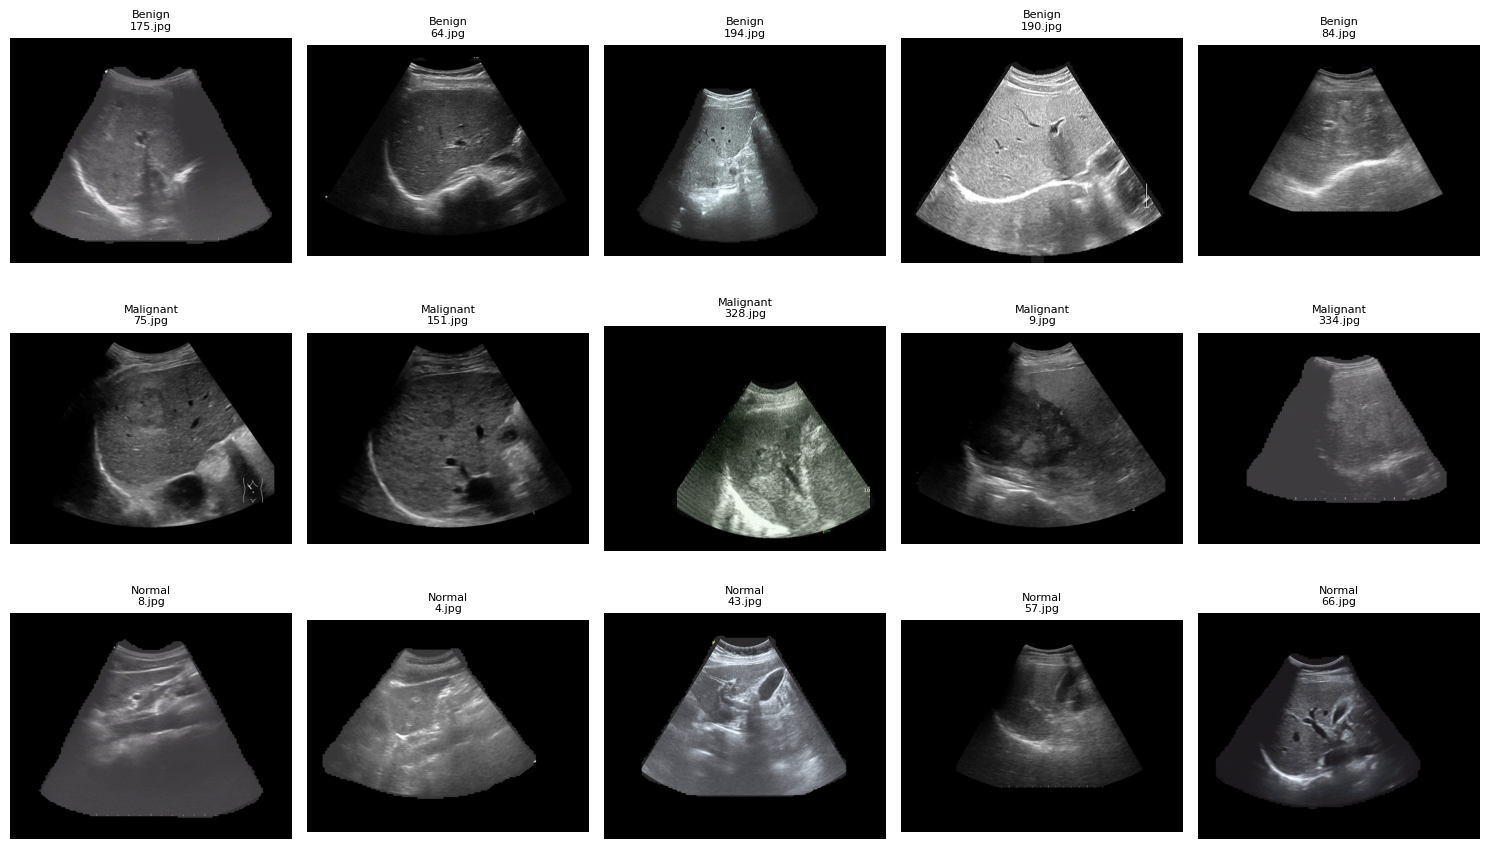

In [48]:
# 5 random images from each class

fig, axes = plt.subplots(nrows=len(categories), ncols=5, figsize=(15, 9))

for row, category in enumerate(categories):
    image_dir = os.path.join(base_path, category, category, "image")
    image_files = [os.path.join(image_dir, file)
                   for file in os.listdir(image_dir)
                   if file.lower().endswith(".jpg")]

    sample_files = random.sample(image_files, 5)

    for col, img_path in enumerate(sample_files):
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[row, col].imshow(img_rgb)
        axes[row, col].axis("off")
        axes[row, col].set_title(f"{category}\n{os.path.basename(img_path)}", fontsize=8)

plt.tight_layout()
plt.show()

## Data Exploration

Image counts per category: {'Benign': 200, 'Malignant': 435, 'Normal': 100}


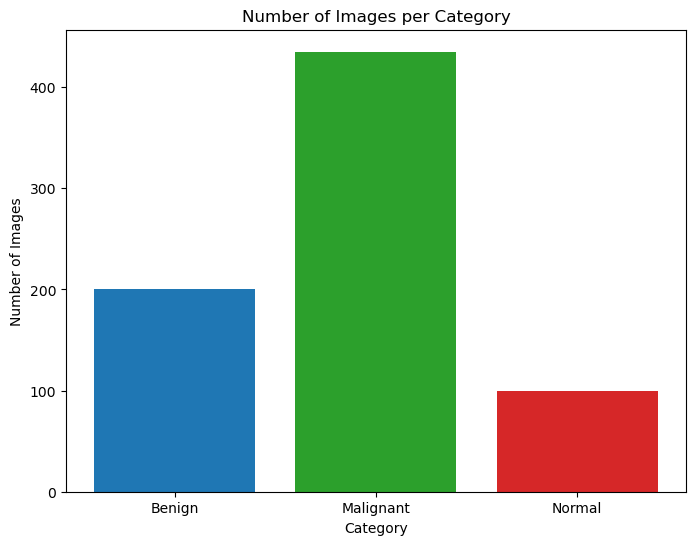

In [49]:
# Counting categories of images

image_counts = {}

for category in categories:
    image_dir = os.path.join(base_path, category, category, "image")
    count = len([file for file in os.listdir(image_dir) if file.endswith(".jpg")])
    image_counts[category] = count

print("Image counts per category:", image_counts)

plt.figure(figsize=(8, 6))
plt.bar(image_counts.keys(), image_counts.values(), color=['#1f77b4', '#2ca02c', '#d62728'])
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.title("Number of Images per Category")
plt.xticks(list(image_counts.keys()))
plt.show()

Doesn't seem like enough "Normal" images. Consider augmenting to have equal number of benign, malignant, and normal images.

Image dimensions summary:
          width                   height                 
            min   max        mean    min  max        mean
category                                                 
Benign      550  1388  803.380000    407  910  621.460000
Malignant   440  1388  945.328736    341  910  713.804598
Normal      602   768  707.420000    480  576  555.510000


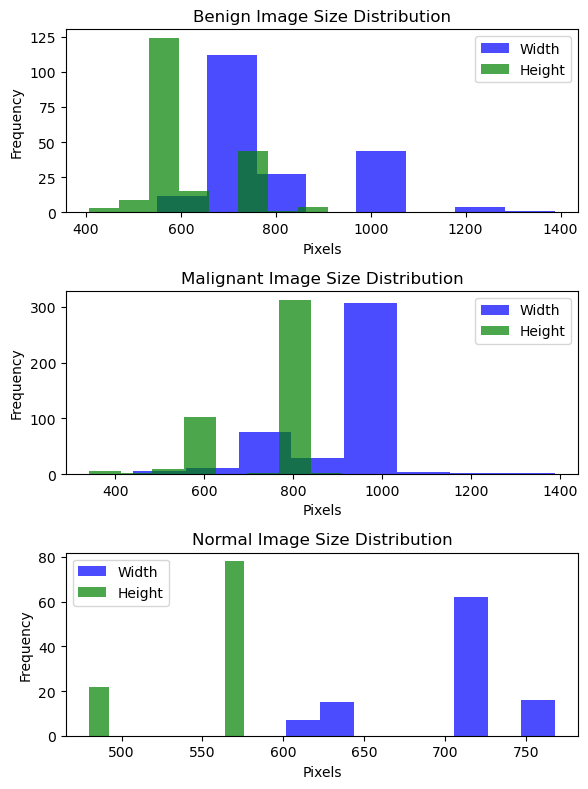

In [50]:
# Comparing dimensions of images

data = {'category': [], 'width': [], 'height': []}

for category in categories:
    image_dir = os.path.join(base_path, category, category, "image")
    for file_name in os.listdir(image_dir):
        if file_name.lower().endswith('.jpg'):
            image_path = os.path.join(image_dir, file_name)
            img = cv2.imread(image_path)
            if img is None:
                continue
            height, width, _ = img.shape
            data['category'].append(category)
            data['width'].append(width)
            data['height'].append(height)

df = pd.DataFrame(data)
print("Image dimensions summary:")
print(df.groupby("category").agg({"width": ["min", "max", "mean"], "height": ["min", "max", "mean"]}))


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 8))
bins = 8

for i, cat in enumerate(categories):
    sub_df = df[df["category"] == cat]
    axes[i].hist(sub_df["width"], bins=bins, alpha=0.7, label="Width", color='blue')
    axes[i].hist(sub_df["height"], bins=bins, alpha=0.7, label="Height", color='green')
    axes[i].set_title(f"{cat} Image Size Distribution")
    axes[i].set_xlabel("Pixels")
    axes[i].set_ylabel("Frequency")
    axes[i].legend()

plt.tight_layout()
plt.show()

Image sizes vary a lot. Let's standardize them.

## Data Transformation

### Resize

In [118]:
# Paths for new resized images
base_path = path + "/7272660"
output_path = path + "/resized"

# Config
target_size = (512, 512)
categories = ["Benign", "Malignant", "Normal"]
segments = ["liver", "mass", "outline"]

# Function to ensure output dirs exist
def ensure_dir(path):
    if not os.path.isdir(path):
        os.makedirs(path, exist_ok=True)

# Loop
for category in categories:
    img_in = os.path.join(base_path, category, category, "image")
    seg_in = os.path.join(base_path, category, category, "segmentation")
    img_out = os.path.join(output_path, category, category, "image")
    seg_out = os.path.join(output_path, category, category, "segmentation")

    ensure_dir(img_out)
    ensure_dir(seg_out)
    for seg in segments:
        ensure_dir(os.path.join(seg_out, seg))

    for file in os.listdir(img_in):
        if not file.lower().endswith(".jpg"):
            continue

        # Resize image
        src_img_path = os.path.join(img_in, file)
        img = cv2.imread(src_img_path)
        h0, w0 = img.shape[:2]
        sy = target_size[0] / h0
        sx = target_size[1] / w0

        resized = cv2.resize(img, (target_size[1], target_size[0]),  interpolation=cv2.INTER_LINEAR)
        out_img_path = os.path.join(img_out, file)
        cv2.imwrite(out_img_path, resized)

        # Process segmentation json
        for seg in segments:
            in_json = os.path.join(seg_in, seg, file.replace(".jpg", ".json"))
            out_json = os.path.join(seg_out, seg, file.replace(".jpg", ".json"))

            if not os.path.isfile(in_json):
                continue

            with open(in_json, 'r') as fi:
                coords = json.load(fi)

            scaled = [[x * sx, y * sy] for (x, y) in coords]

            with open(out_json, 'w') as fo:
                json.dump(scaled, fo)

print("Done! All images are now 512×512 and JSONs have been scaled accordingly.")

Done! All images are now 512×512 and JSONs have been scaled accordingly.


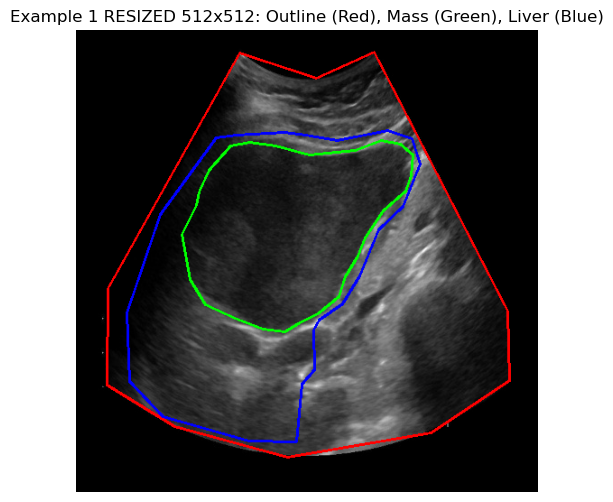

In [119]:
# Plotting an example of liver image with the annotations

base_path = path + "/7272660/Benign/Benign/"

# File paths for image and corresponding annotation JSON files for example #1

# Define file paths for image and corresponding annotation JSON files
image_path   = base_path + "image/1.jpg"
outline_path = base_path + "segmentation/outline/1.json"
mass_path    = base_path + "segmentation/mass/1.json"
liver_path   = base_path + "segmentation/liver/1.json"

# Load image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert the image from BGR (OpenCV default) to RGB (for display with matplotlib)

# Function to load polygon coordinates from a JSON file
def load_polygon(json_path):
    with open(json_path, 'r') as file:
        coords = json.load(file)
    # Convert list of coordinates to a numpy array and reshape for cv2.polylines
    polygon = np.array(coords, dtype=np.int32).reshape((-1, 1, 2))
    return polygon

# Load the polygons for each category
outline_polygon = load_polygon(outline_path)
mass_polygon    = load_polygon(mass_path)
liver_polygon   = load_polygon(liver_path)

# Create a copy of the image to draw the overlays
overlay = image_rgb.copy()

# Draw each polygon on the image. Using distinct colors for each:
# - Outline: Red, - Mass: Green, - Liver: Blue.
cv2.polylines(overlay, [outline_polygon], isClosed=True, color=(255, 0, 0), thickness=2)
cv2.polylines(overlay, [mass_polygon],    isClosed=True, color=(0, 255, 0), thickness=2)
cv2.polylines(overlay, [liver_polygon],   isClosed=True, color=(0, 0, 255), thickness=2)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title("Example 1 RESIZED 512x512: Outline (Red), Mass (Green), Liver (Blue)")
plt.axis('off')
plt.show()

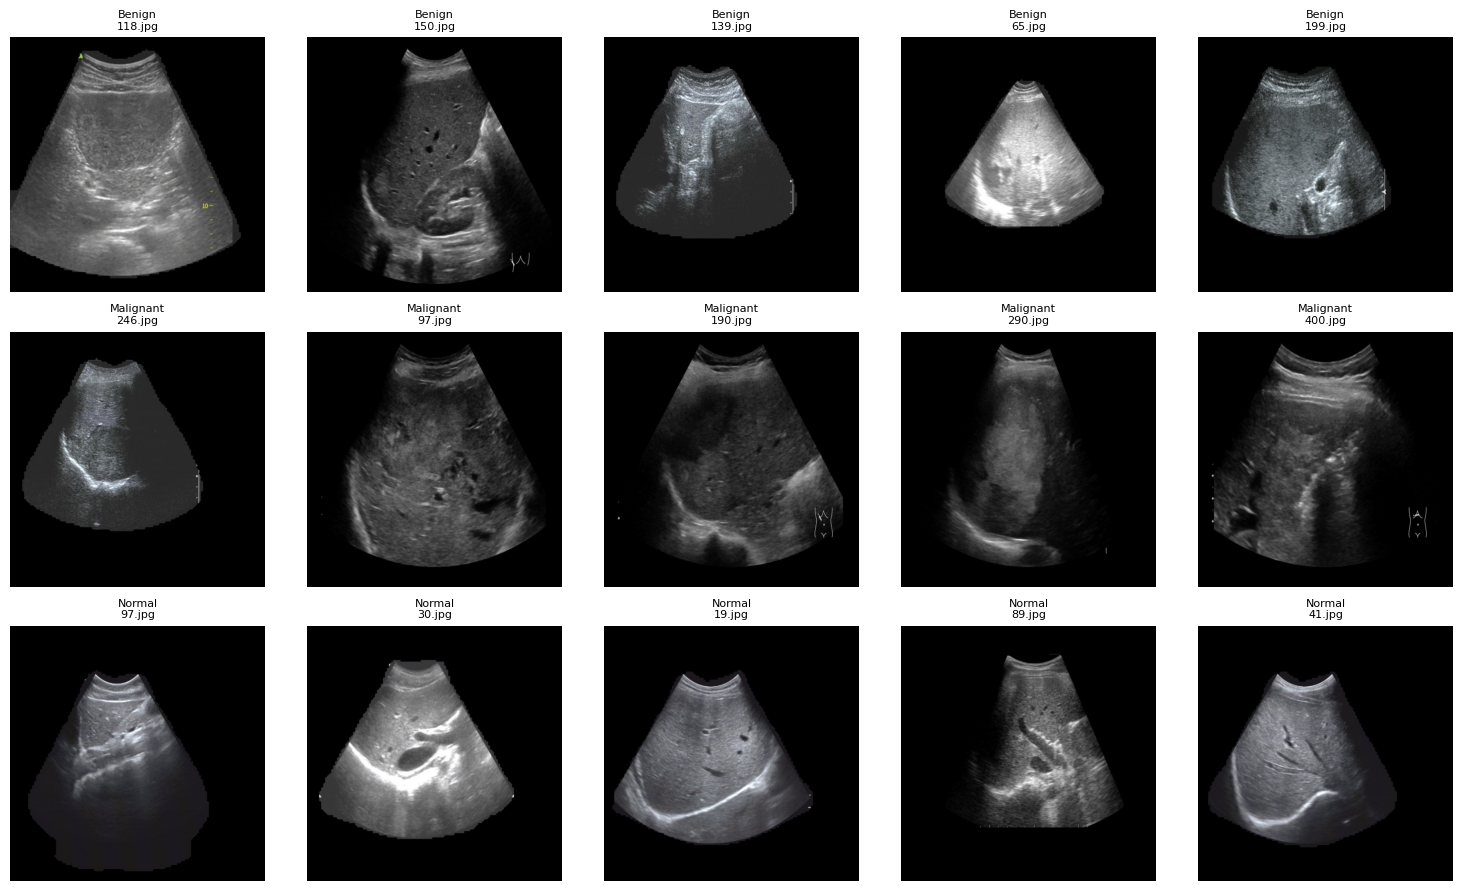

In [120]:
# 5 random images from each class RESIZED

base_path = path + "/resized"

fig, axes = plt.subplots(nrows=len(categories), ncols=5, figsize=(15, 9))

for row, category in enumerate(categories):
    image_dir = os.path.join(base_path, category, category, "image")
    image_files = [os.path.join(image_dir, file)
                   for file in os.listdir(image_dir)
                   if file.lower().endswith(".jpg")]

    sample_files = random.sample(image_files, 5)

    for col, img_path in enumerate(sample_files):
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[row, col].imshow(img_rgb)
        axes[row, col].axis("off")
        axes[row, col].set_title(f"{category}\n{os.path.basename(img_path)}", fontsize=8)

plt.tight_layout()
plt.show()

### Sampling Size (Augmentation)

We have {'Benign': 200, 'Malignant': 435, 'Normal': 100}. To minimize variance we should have equal number from each class.

Strategies to consider:
- Undersample the majority class by randomly selecting target number
- Oversample via augmentation the lacking ones to target number

There's pros & cons for either approach. Let's combine both for a good middle ground. For this example, the most important thing is to detect when there is a malicious mass in the liver. So let's split 50% Malicious and 50% Benign/Normal.

Target:
- Benign: 250 (augment by 50)
- Normal: 150 (augment by 50)
- Malignant: 400 (reduce by 35)

Let's augment copies of images varying in
- Flipping images sideways
- Randomly crop outer edges and then resize to 512x512
- Jitters in brightness and contrast

In [121]:
# Config
BASE_IN       = path + "/resized"
BASE_OUT      = path + "/resized_transformed"
TARGET_COUNTS = {"Benign":250, "Normal":150, "Malignant":400}
CATEGORIES    = ["Benign","Normal","Malignant"]
SEG_TYPES     = ["liver","mass","outline"]
IMG_SIZE      = 512

# Augmentation pipeline
augment = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE),
                            scale=(0.8, 1.0), ratio=(1.0, 1.0), p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2,
                                   contrast_limit=0.2, p=0.5),
    ],
    additional_targets={
        "mask0": "mask",   # liver
        "mask1": "mask",   # mass
        "mask2": "mask",   # outline
    }
)

def json_to_mask(jpath, shape):
    """Load polygon JSON → binary mask, or zero mask on error."""
    mask = np.zeros(shape, dtype=np.uint8)
    if not os.path.isfile(jpath):
        return mask
    try:
        coords = json.load(open(jpath))
        pts = np.array(coords, dtype=np.int32)
        if pts.ndim == 2 and pts.shape[0] >= 3 and pts.shape[1] == 2:
            pts = pts.reshape(-1, 1, 2)
            cv2.fillPoly(mask, [pts], 1)
    except Exception:
        pass
    return mask

def mask_to_poly(m):
    """Convert binary mask → simplified polygon coords."""
    cnts, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return []
    c = max(cnts, key=cv2.contourArea)
    eps = 0.005 * cv2.arcLength(c, True)
    poly = cv2.approxPolyDP(c, eps, True).reshape(-1, 2)
    return poly.astype(float).tolist()

def copy_original(img_in, img_out, seg_in, seg_out):
    """Copy image + its JSON segmentation files."""
    shutil.copy(img_in, img_out)
    for s in SEG_TYPES:
        src = os.path.join(seg_in, s, os.path.basename(img_in).replace(".jpg", ".json"))
        dst = os.path.join(seg_out, s, os.path.basename(img_out).replace(".jpg", ".json"))
        if os.path.isfile(src):
            shutil.copy(src, dst)

# Loop
for cat in CATEGORIES:
    in_img_dir  = os.path.join(BASE_IN,  cat, cat, "image")
    in_seg_dir  = os.path.join(BASE_IN,  cat, cat, "segmentation")
    out_img_dir = os.path.join(BASE_OUT, cat, cat, "image")
    out_seg_dir = os.path.join(BASE_OUT, cat, cat, "segmentation")
    os.makedirs(out_img_dir, exist_ok=True)
    for s in SEG_TYPES:
        os.makedirs(os.path.join(out_seg_dir, s), exist_ok=True)

    all_imgs = [f for f in os.listdir(in_img_dir) if f.lower().endswith(".jpg")]

    # Malignant: undersample to 400, no augment
    if cat == "Malignant":
        selected = random.sample(all_imgs, TARGET_COUNTS[cat])
        for f in selected:
            copy_original(
                os.path.join(in_img_dir, f),
                os.path.join(out_img_dir, f),
                in_seg_dir, out_seg_dir
            )
        print(f"Malignant: copied {len(selected)} images (target {TARGET_COUNTS[cat]})")
        continue

    # Benign & Normal: copy originals + augment
    # Copy originals
    for f in all_imgs:
        copy_original(
            os.path.join(in_img_dir, f),
            os.path.join(out_img_dir, f),
            in_seg_dir, out_seg_dir
        )

    # Augment to reach target count
    need = TARGET_COUNTS[cat] - len(all_imgs)
    for i in range(need):
        src = random.choice(all_imgs)
        img = cv2.imread(os.path.join(in_img_dir, src))
        h, w = img.shape[:2]

        # Build masks in order: liver, mass, outline
        masks = [
            json_to_mask(os.path.join(in_seg_dir, seg, src.replace(".jpg", ".json")), (h, w))
            for seg in SEG_TYPES
        ]

        # Prepare Albumentations input
        inp = {"image": img, "mask0": masks[0], "mask1": masks[1], "mask2": masks[2]}
        aug = augment(**inp)

        img_a    = aug["image"]
        masks_a  = [aug[f"mask{idx}"] for idx in range(len(masks))]
        name     = src.replace(".jpg", f"_aug_{i+1}.jpg")
        cv2.imwrite(os.path.join(out_img_dir, name), img_a)

        # Convert each augmented mask back to JSON polygons
        for seg, m in zip(SEG_TYPES, masks_a):
            poly = mask_to_poly(m)
            json.dump(
                poly,
                open(os.path.join(out_seg_dir, seg, name.replace(".jpg", ".json")), "w")
            )

# Final counts
print("\nFinal image counts:")
for cat in CATEGORIES:
    cnt = sum(
        1 for f in os.listdir(os.path.join(BASE_OUT, cat, cat, "image"))
        if f.lower().endswith(".jpg")
    )
    print(f"  {cat}: {cnt} images")

Malignant: copied 400 images (target 400)

Final image counts:
  Benign: 250 images
  Normal: 150 images
  Malignant: 400 images


That was a complex code! Let's check the transformations have been applied correctly.

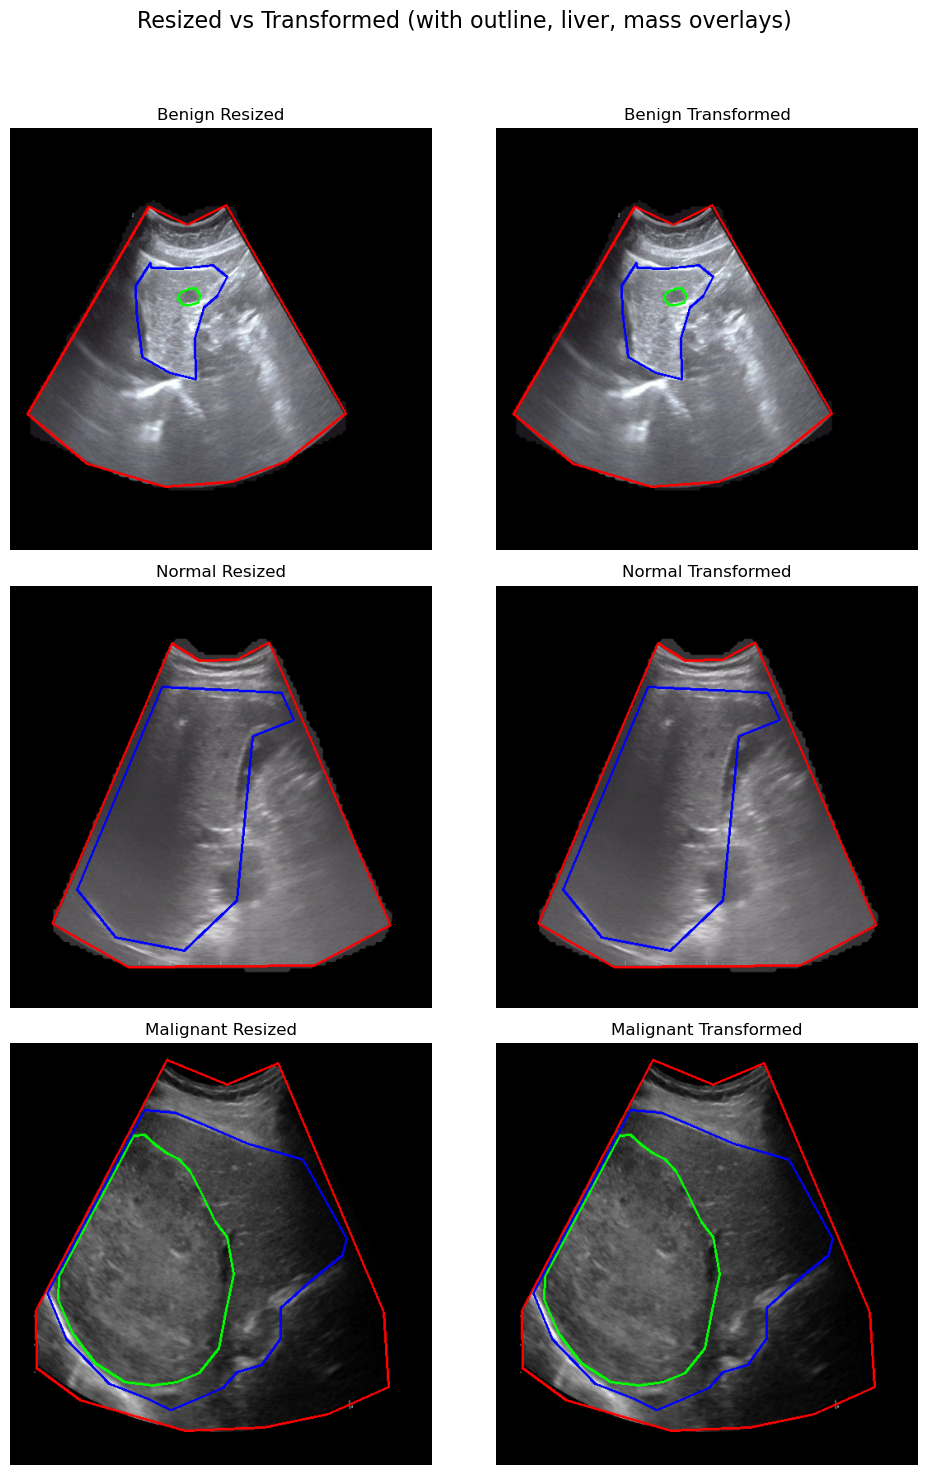

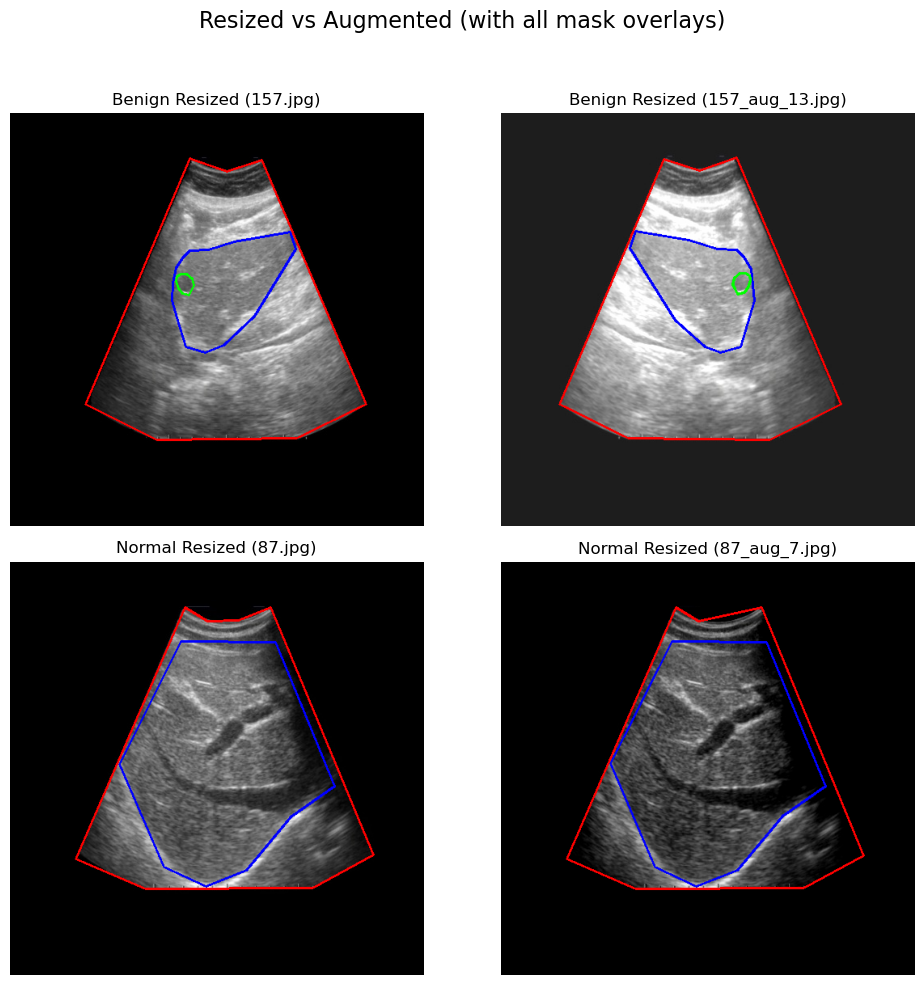

In [136]:
# Config
BASE_RESIZED       = path + "/resized"
BASE_TRANSFORMED   = path + "/resized_transformed"
CATEGORIES_ALL     = ["Benign", "Normal", "Malignant"]
CATEGORIES_AUG     = ["Benign", "Normal"]  # only these were augmented
IMG_SUBDIR         = "image"
SEG_DIR            = "segmentation"
MASK_TYPES         = ["outline", "liver", "mass"]
MASK_COLORS        = {
    "outline": (255, 0, 0),
    "liver":   (0, 0, 255),
    "mass":    (0, 255, 0)
}
NUM_COMPARE        = 3  # # of resized vs transformed samples per category

def overlay_masks(img, mask_paths):
    """Draw each mask polygon onto img in-place using MASK_COLORS."""
    for m in MASK_TYPES:
        jp = mask_paths.get(m)
        if jp and os.path.isfile(jp):
            pts = np.array(json.load(open(jp)), dtype=np.int32)
            if pts.ndim == 2 and pts.shape[0] >= 3 and pts.shape[1] == 2:
                pts = pts.reshape(-1, 1, 2)
                cv2.polylines(img, [pts], isClosed=True,
                              color=MASK_COLORS[m], thickness=2)
    return img

def load_and_overlay_all(img_path, base_dir, cat, fname):
    """Load image from img_path and overlay outline, liver, mass."""
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    seg_base = os.path.join(base_dir, cat, cat, SEG_DIR)
    mask_paths = {
        m: os.path.join(seg_base, m, fname.replace(".jpg", ".json"))
        for m in MASK_TYPES
    }
    return overlay_masks(img_rgb, mask_paths)

# Resized vs Transformed (all categories)
fig, axes = plt.subplots(len(CATEGORIES_ALL), 2,
                         figsize=(10, 5 * len(CATEGORIES_ALL)))
fig.suptitle("Resized vs Transformed (with outline, liver, mass overlays)", fontsize=16)

for i, cat in enumerate(CATEGORIES_ALL):
    orig_dir  = os.path.join(BASE_RESIZED,     cat, cat, IMG_SUBDIR)
    trans_dir = os.path.join(BASE_TRANSFORMED, cat, cat, IMG_SUBDIR)
    orig_files  = [f for f in os.listdir(orig_dir)  if f.endswith(".jpg") and "_aug_" not in f]
    trans_files = [f for f in os.listdir(trans_dir) if f.endswith(".jpg") and "_aug_" not in f]
    shared      = list(set(orig_files).intersection(trans_files))
    sample      = random.sample(shared, min(NUM_COMPARE, len(shared)))
    
    for j, fname in enumerate(sample):
        # Resized
        orig_img = os.path.join(orig_dir, fname)
        img_o = load_and_overlay_all(orig_img, BASE_RESIZED, cat, fname)
        axes[i, 0].imshow(img_o)
        axes[i, 0].axis("off")
        axes[i, 0].set_title(f"{cat} Resized")
        # Transformed
        trans_img = os.path.join(trans_dir, fname)
        img_t = load_and_overlay_all(trans_img, BASE_TRANSFORMED, cat, fname)
        axes[i, 1].imshow(img_t)
        axes[i, 1].axis("off")
        axes[i, 1].set_title(f"{cat} Transformed")

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# Original vs Augmented (Benign & Normal)
fig2, axes2 = plt.subplots(len(CATEGORIES_AUG), 2,
                           figsize=(10, 5 * len(CATEGORIES_AUG)))
fig2.suptitle("Resized vs Augmented (with all mask overlays)", fontsize=16)

for i, cat in enumerate(CATEGORIES_AUG):
    trans_dir = os.path.join(BASE_TRANSFORMED, cat, cat, IMG_SUBDIR)
    aug_files = [f for f in os.listdir(trans_dir)
                 if f.endswith(".jpg") and "_aug_" in f]
    aug_sample = random.choice(aug_files)
    base_name  = aug_sample.split("_aug_")[0] + ".jpg"

    # Original
    orig_img = os.path.join(BASE_RESIZED, cat, cat, IMG_SUBDIR, base_name)
    img_o = load_and_overlay_all(orig_img, BASE_RESIZED, cat, base_name)
    axes2[i, 0].imshow(img_o)
    axes2[i, 0].axis("off")
    axes2[i, 0].set_title(f"{cat} Resized ({base_name})")

    # Augmented
    aug_img = os.path.join(trans_dir, aug_sample)
    img_a = load_and_overlay_all(aug_img, BASE_TRANSFORMED, cat, aug_sample)
    axes2[i, 1].imshow(img_a)
    axes2[i, 1].axis("off")
    axes2[i, 1].set_title(f"{cat} Resized ({aug_sample})")

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

## Model

### Binary Classification

Set up for binary classification purposes

In [137]:
# Config
BASE_DIR = path + "/resized_transformed"
CATEGORIES = ["Benign", "Normal", "Malignant"]
IMG_SUBDIR = os.path.join("image")
SEG_SUBDIR = os.path.join("segmentation")

In [138]:
# Collect all samples
records = []

for cat in CATEGORIES:
    img_dir = os.path.join(BASE_DIR, cat, cat, IMG_SUBDIR)
    seg_dir = os.path.join(BASE_DIR, cat, cat, SEG_SUBDIR)
    for img_name in os.listdir(img_dir):
        if not img_name.endswith(".jpg"):
            continue 

        img_path = os.path.join(img_dir, img_name)
        liver_path = os.path.join(seg_dir, "liver", img_name.replace(".jpg", ".json"))
        outline_path = os.path.join(seg_dir, "outline", img_name.replace(".jpg", ".json"))
        mass_path = os.path.join(seg_dir, "mass", img_name.replace(".jpg", ".json"))
        if not os.path.exists(mass_path):
            mass_path = None # Normal has no mass -> set None

        # Binary classification: 1 for Malignant, 0 otherwise
        label = 1 if cat == "Malignant" else 0

        records.append({
            "image": img_path,
            "liver": liver_path,
            "outline": outline_path,
            "mass": mass_path,
            "label": label
        })

m1_df = pd.DataFrame(records)
print("Total samples:", len(m1_df))
print(m1_df["label"].value_counts())

Total samples: 800
label
0    400
1    400
Name: count, dtype: int64


In [139]:
# Train/Test Split

m1_df_train, m1_df_test = train_test_split(
    m1_df,
    test_size=0.2,
    stratify=m1_df["label"],
    random_state=42
)

m1_df_train.to_csv("train_manifest.csv", index=False)
m1_df_test.to_csv("test_manifest.csv", index=False)

print("Train samples:", len(m1_df_train))
print(" Test samples:", len(m1_df_test))

Train samples: 640
 Test samples: 160


Into PyTorch dataset

In [14]:
# class LiverBinaryDataset(Dataset):
#     def __init__(self, df, img_transform=None):
#         """
#         df: DataFrame with columns ['image','liver','outline','mass','label']
#         img_transform: torchvision.transforms to apply to the PIL image (e.g. Normalize)
#         """
#         self.df = df.reset_index(drop=True)
#         self.img_transform = img_transform

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]

#         # ---- 1) Load image ----
#         # OpenCV loads BGR, convert to RGB and to PIL for torchvision
#         img_bgr = cv2.imread(row['image'])
#         img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

#         # ---- 2) Rasterize masks ----
#         h, w = img_rgb.shape[:2]
#         masks = []
#         for key in ['liver','outline','mass']:
#             path = row[key]
#             mask = np.zeros((h, w), dtype=np.uint8)

#             # only try to load/draw if the JSON exists
#             if path and os.path.exists(path):
#                 coords = json.load(open(path))     # hopefully a list of [x,y]
#                 if isinstance(coords, list) and len(coords) >= 3:
#                     pts = np.array(coords, dtype=np.int32)
#                     # ensure shape (n_points, 2)
#                     if pts.ndim == 2 and pts.shape[1] == 2:
#                         pts = pts.reshape(-1, 1, 2)  # (n_points,1,2)
#                         cv2.fillPoly(mask, [pts], 1)
#             masks.append(mask)
#         # Stack into (3, H, W)
#         mask_stack = np.stack(masks, axis=0)

#         # ---- 3) Convert to tensors ----
#         # Image: H×W×3 -> C×H×W, float in [0,1]
#         img_tensor = torch.from_numpy(img_rgb).permute(2,0,1).float().div(255.0)
#         # Apply any torchvision transforms (e.g. Normalize) if provided
#         if self.img_transform:
#             img_tensor = self.img_transform(img_tensor)
#         # Masks: already 0/1, convert to float tensor
#         mask_tensor = torch.from_numpy(mask_stack).float()

#         # Label: binary {0,1}
#         label = torch.tensor(row['label'], dtype=torch.float32)

#         return img_tensor, mask_tensor, label

In [142]:
from LiverBinaryDataset import LiverBinaryDataset

In [143]:
img_transform = Compose([
    Normalize(mean=[0.485, 0.456, 0.406],
              std =[0.229, 0.224, 0.225])
])

m1_train = LiverBinaryDataset(m1_df_train, img_transform=img_transform)
m1_test  = LiverBinaryDataset(m1_df_test,  img_transform=img_transform)

train_loader = DataLoader(m1_train, batch_size=16, shuffle=True,  num_workers=4)
test_loader  = DataLoader(m1_test,  batch_size=16, shuffle=False, num_workers=4)

#### Model 1: Binary Classification with CNN

Let's build a Convolutional Neural Network (CNN) to binary classify liver status.

We'll build four hidden layers (convolutional "blocks") with:
- Conv2d - The convolution filters (windows) across the image into feature maps
- BatchNorm2d - Scaling convolution outputs
- ReLU Activation
- MaxPool2d - Max Pooling to downsample feature map 

In [161]:
class SimpleLiverCNN(nn.Module):
    def __init__(self, in_channels=6):
        super().__init__()

        # Convolutional Blocks
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1), # 512 -> 512
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2), # 512 -> 256

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # 256 -> 256
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2), # 256 -> 128

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 128 -> 128
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2), # 128 -> 64

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 64 -> 64
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),
            nn.AdaptiveAvgPool2d((1, 1)) # 64 -> 1
        )

        # Fully Connected Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(), # 128
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 1) # 1 output
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

In [163]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model   = SimpleLiverCNN(in_channels=6).to(device)
criterion = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Utility to print layer output shapes
def print_layer_outputs(model, x):
    model.eval()
    out = x
    print("=== Encoder outputs ===")
    for name, module in model.encoder.named_children():
        out = module(out)
        print(f"{name:<15} -> {tuple(out.shape)}")
    print("=== Classifier outputs ===")
    for name, module in model.classifier.named_children():
        out = module(out)
        print(f"{name:<15} -> {tuple(out.shape)}")
    print()

# Training loop with loss/accuracy tracking
num_epochs = 5
train_losses = []
test_losses  = []
test_accs    = []

for epoch in range(1, num_epochs+1):
    # -- train --
    model.train()
    running_loss = 0.0
    for images, masks, labels in train_loader:
        images = images.to(device)
        masks  = masks.to(device)
        labels = labels.to(device)
        inputs = torch.cat([images, masks], dim=1)

        optimizer.zero_grad()
        logits = model(inputs).squeeze(1)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # -- evaluate on test set --
    model.eval()
    test_loss = 0.0
    correct   = 0
    total     = 0
    with torch.no_grad():
        for images, masks, labels in test_loader:
            images = images.to(device)
            masks  = masks.to(device)
            labels = labels.to(device)
            inputs = torch.cat([images, masks], dim=1)
            logits = model(inputs).squeeze(1)
            test_loss += criterion(logits, labels).item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    avg_test_loss = test_loss / len(test_loader)
    test_acc      = correct / total
    test_losses.append(avg_test_loss)
    test_accs.append(test_acc)

    print(f"Epoch {epoch}/{num_epochs}  "
          f"Train Loss: {avg_train_loss:.4f}  "
          f"Test Loss: {avg_test_loss:.4f}  "
          f"Test Acc: {test_acc*100:.2f}%")

Epoch 1/5  Train Loss: 0.6912  Test Loss: 0.6761  Test Acc: 53.75%
Epoch 2/5  Train Loss: 0.6543  Test Loss: 0.6337  Test Acc: 71.88%
Epoch 3/5  Train Loss: 0.6284  Test Loss: 0.6134  Test Acc: 71.25%
Epoch 4/5  Train Loss: 0.5982  Test Loss: 0.5906  Test Acc: 72.50%
Epoch 5/5  Train Loss: 0.5780  Test Loss: 0.5767  Test Acc: 72.50%


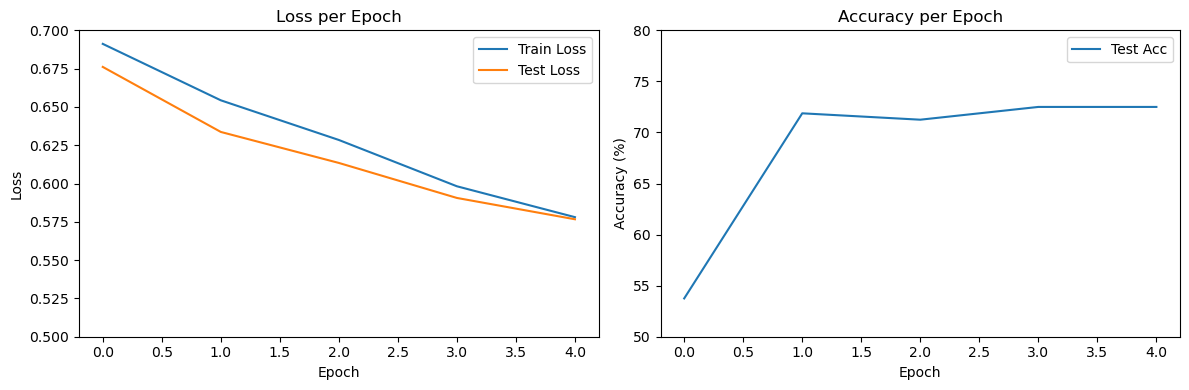

In [165]:
# Plot loss and accuracy curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(train_losses, label="Train Loss")
ax1.plot(test_losses,  label="Test Loss")
ax1.set_title("Loss per Epoch")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_ylim(0.5, 0.7)
ax1.legend()

ax2.plot([a*100 for a in test_accs], label="Test Acc")
ax2.set_title("Accuracy per Epoch")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_ylim(50, 80)
ax2.legend()

plt.tight_layout()
plt.show()

In [166]:
# Inspect layer shapes on one batch
batch = next(iter(train_loader))
images, masks, _ = batch
images = images.to(device); masks = masks.to(device)
inputs = torch.cat([images, masks], dim=1)
print_layer_outputs(model, inputs)

=== Encoder outputs ===
0               -> (16, 16, 512, 512)
1               -> (16, 16, 512, 512)
2               -> (16, 16, 512, 512)
3               -> (16, 16, 512, 512)
4               -> (16, 16, 256, 256)
5               -> (16, 32, 256, 256)
6               -> (16, 32, 256, 256)
7               -> (16, 32, 256, 256)
8               -> (16, 32, 256, 256)
9               -> (16, 32, 128, 128)
10              -> (16, 64, 128, 128)
11              -> (16, 64, 128, 128)
12              -> (16, 64, 128, 128)
13              -> (16, 64, 128, 128)
14              -> (16, 64, 64, 64)
15              -> (16, 128, 64, 64)
16              -> (16, 128, 64, 64)
17              -> (16, 128, 64, 64)
18              -> (16, 128, 64, 64)
19              -> (16, 128, 1, 1)
=== Classifier outputs ===
0               -> (16, 128)
1               -> (16, 64)
2               -> (16, 64)
3               -> (16, 64)
4               -> (16, 1)



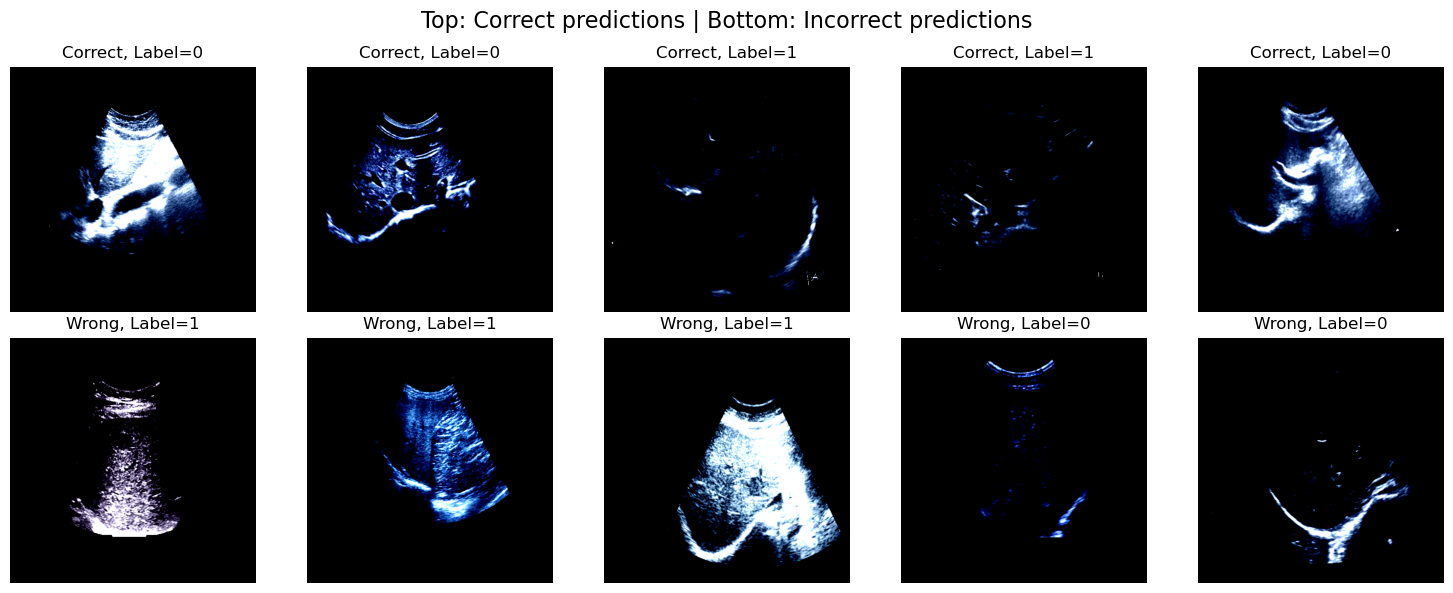

In [167]:
# Show correct vs incorrect test images

# Collect up to 5 of each
correct_imgs, correct_lbls = [], []
wrong_imgs,   wrong_lbls   = [], []
with torch.no_grad():
    for images, masks, labels in test_loader:
        images = images.to(device)
        masks  = masks.to(device)
        labels = labels.to(device)
        inputs = torch.cat([images, masks], dim=1)
        logits  = model(inputs).squeeze(1)
        probs   = torch.sigmoid(logits)
        preds   = (probs > 0.5).float()
        for i in range(len(labels)):
            img_tensor = images[i].cpu()
            # Un-normalize if you used Normalize
            # img = img_tensor * std + mean
            img_np = img_tensor.permute(1,2,0).clamp(0,1).numpy()
            if preds[i] == labels[i] and len(correct_imgs) < 5:
                correct_imgs.append(img_np)
                correct_lbls.append(int(labels[i].item()))
            elif preds[i] != labels[i] and len(wrong_imgs) < 5:
                wrong_imgs.append(img_np)
                wrong_lbls.append(int(labels[i].item()))
        if len(correct_imgs) >= 5 and len(wrong_imgs) >= 5:
            break

# Plot them
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axes[0, i].imshow(correct_imgs[i])
    axes[0, i].set_title(f"Correct, Label={correct_lbls[i]}")
    axes[0, i].axis("off")
    axes[1, i].imshow(wrong_imgs[i])
    axes[1, i].set_title(f"Wrong, Label={wrong_lbls[i]}")
    axes[1, i].axis("off")
plt.suptitle("Top: Correct predictions | Bottom: Incorrect predictions", fontsize=16)
plt.tight_layout()
plt.show()

### Multi-class Classification

In [173]:
# Config
BASE_DIR = path + "/resized_transformed"
CATEGORIES = ["Benign", "Normal", "Malignant"]
label_map = {cat: idx for idx, cat in enumerate(CATEGORIES)} # Benign=0, Normal=1, Malignant=2
IMG_SUBDIR = "image"
SEG_SUBDIR = "segmentation"

In [180]:
# Collect all samples
records = []

for cat in CATEGORIES:
    img_dir = os.path.join(BASE_DIR, cat, cat, IMG_SUBDIR)
    seg_dir = os.path.join(BASE_DIR, cat, cat, SEG_SUBDIR)
    for img_name in os.listdir(img_dir):
        if not img_name.endswith(".jpg"):
            continue 

        img_path = os.path.join(img_dir, img_name)
        liver_path = os.path.join(seg_dir, "liver", img_name.replace(".jpg", ".json"))
        outline_path = os.path.join(seg_dir, "outline", img_name.replace(".jpg", ".json"))
        mass_path = os.path.join(seg_dir, "mass", img_name.replace(".jpg", ".json"))
        if not os.path.exists(mass_path):
            mass_path = None # Normal has no mass -> set None

        records.append({
            "image": img_path,
            "liver": liver_path,
            "outline": outline_path,
            "mass": mass_path,
            "label": label_map[cat]
        })

m2_df = pd.DataFrame(records)
print("Total samples:", len(m2_df))
print(m2_df["label"].value_counts().sort_index().rename(index={0:"Benign",1:"Normal",2:"Malignant"}))

Total samples: 800
label
Benign       250
Normal       150
Malignant    400
Name: count, dtype: int64


In [181]:
# Train/Test Split

m2_df_train, m2_df_test = train_test_split(
    m2_df,
    test_size=0.2,
    stratify=m2_df["label"],
    random_state=42
)

m2_df_train.to_csv("train_manifest_m2.csv", index=False)
m2_df_test.to_csv("test_manifest_m2.csv", index=False)

print("Train samples:", len(m2_df_train))
print("Test samples:", len(m2_df_test))

Train samples: 640
Test samples: 160


In [182]:
from LiverMulticlassDataset import LiverMulticlassDataset

In [183]:
img_transform = Compose([
    Normalize(mean=[0.485, 0.456, 0.406],
              std =[0.229, 0.224, 0.225])
])

m2_train = LiverMulticlassDataset(m2_df_train, img_transform=img_transform)
m2_test  = LiverMulticlassDataset(m2_df_test,  img_transform=img_transform)

train_loader = DataLoader(m2_train, batch_size=16, shuffle=True,  num_workers=4)
test_loader  = DataLoader(m2_test,  batch_size=16, shuffle=False, num_workers=4)

#### Model 2: Multiclass Classification with CNN

In [185]:
class MultiLiverCNN(nn.Module):
    def __init__(self, in_channels=6, num_classes=3):
        super().__init__()

        # Convolutional Blocks
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1), # 512 -> 512
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2), # 512 -> 256

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # 256 -> 256
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2), # 256 -> 128

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 128 -> 128
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2), # 128 -> 64

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 64 -> 64
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),
            nn.AdaptiveAvgPool2d((1, 1)) # 64 -> 1
        )

        # Fully Connected Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(), # 128
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes) # now outputs 3 logits
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

In [188]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model   = MultiLiverCNN(in_channels=6, num_classes=3).to(device)
criterion = nn.CrossEntropyLoss() # Now different loss function
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Utility to print layer output shapes
def print_layer_outputs(model, x):
    model.eval()
    out = x
    print("=== Encoder outputs ===")
    for name, module in model.encoder.named_children():
        out = module(out)
        print(f"{name:<15} -> {tuple(out.shape)}")
    print("=== Classifier outputs ===")
    for name, module in model.classifier.named_children():
        out = module(out)
        print(f"{name:<15} -> {tuple(out.shape)}")
    print()

# Training loop with loss/accuracy tracking
num_epochs = 5
train_losses = []
test_losses  = []
test_accs    = []

for epoch in range(1, num_epochs+1):
    # -- train --
    model.train()
    running_loss = 0.0
    for images, masks, labels in train_loader:
        images = images.to(device)
        masks  = masks.to(device)
        labels = labels.to(device)
        inputs = torch.cat([images, masks], dim=1)

        optimizer.zero_grad()
        logits = model(inputs)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # -- evaluate on test set --
    model.eval()
    test_loss = 0.0
    correct = 0
    total   = 0
    with torch.no_grad():
        for images, masks, labels in test_loader:
            images = images.to(device)
            masks  = masks.to(device)
            labels = labels.to(device)
            inputs = torch.cat([images, masks], dim=1)
            logits = model(inputs)
            test_loss += criterion(logits, labels).item()
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    avg_test_loss = test_loss / len(test_loader)
    test_acc      = correct / total
    test_losses.append(avg_test_loss)
    test_accs.append(test_acc)

    print(f"Epoch {epoch}/{num_epochs}  "
          f"Train Loss: {avg_train_loss:.4f}  "
          f"Test Loss: {avg_test_loss:.4f}  "
          f"Test Acc: {test_acc*100:.2f}%")

Epoch 1/5  Train Loss: 1.0798  Test Loss: 1.0726  Test Acc: 50.62%
Epoch 2/5  Train Loss: 1.0372  Test Loss: 1.0137  Test Acc: 50.62%
Epoch 3/5  Train Loss: 0.9806  Test Loss: 0.9582  Test Acc: 51.25%
Epoch 4/5  Train Loss: 0.9330  Test Loss: 0.9270  Test Acc: 50.62%
Epoch 5/5  Train Loss: 0.9203  Test Loss: 0.8952  Test Acc: 51.88%


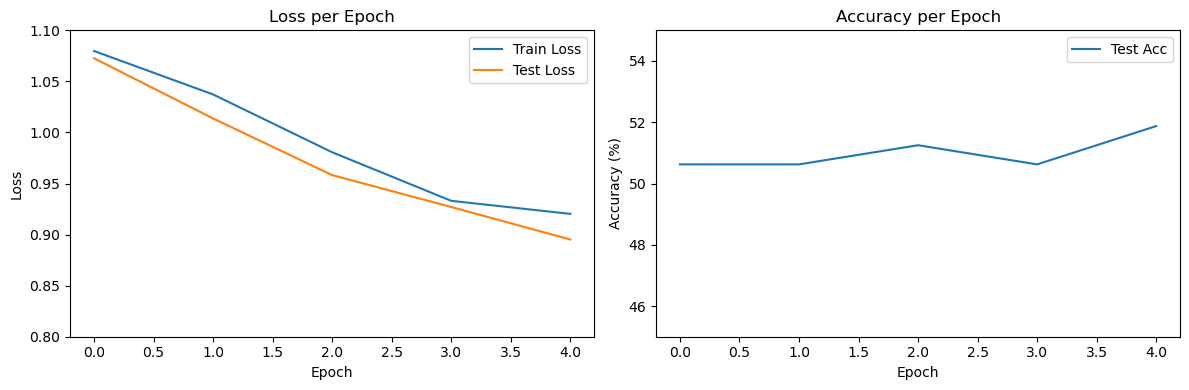

In [191]:
# Plot loss and accuracy curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(train_losses, label="Train Loss")
ax1.plot(test_losses,  label="Test Loss")
ax1.set_title("Loss per Epoch")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_ylim(0.8, 1.1)
ax1.legend()

ax2.plot([a*100 for a in test_accs], label="Test Acc")
ax2.set_title("Accuracy per Epoch")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_ylim(45, 55)
ax2.legend()

plt.tight_layout()
plt.show()

In [192]:
# Inspect layer shapes on one batch
batch = next(iter(train_loader))
images, masks, _ = batch
images = images.to(device); masks = masks.to(device)
inputs = torch.cat([images, masks], dim=1)
print_layer_outputs(model, inputs)

=== Encoder outputs ===
0               -> (16, 16, 512, 512)
1               -> (16, 16, 512, 512)
2               -> (16, 16, 512, 512)
3               -> (16, 16, 512, 512)
4               -> (16, 16, 256, 256)
5               -> (16, 32, 256, 256)
6               -> (16, 32, 256, 256)
7               -> (16, 32, 256, 256)
8               -> (16, 32, 256, 256)
9               -> (16, 32, 128, 128)
10              -> (16, 64, 128, 128)
11              -> (16, 64, 128, 128)
12              -> (16, 64, 128, 128)
13              -> (16, 64, 128, 128)
14              -> (16, 64, 64, 64)
15              -> (16, 128, 64, 64)
16              -> (16, 128, 64, 64)
17              -> (16, 128, 64, 64)
18              -> (16, 128, 64, 64)
19              -> (16, 128, 1, 1)
=== Classifier outputs ===
0               -> (16, 128)
1               -> (16, 64)
2               -> (16, 64)
3               -> (16, 64)
4               -> (16, 3)

